In [2]:
# # Загрузите файл на основе его идентификатора файла.
# file_id = '18DbC6Xj4NP-hLzI14WuMaAEyq482vNfn'

# # Скачать набор данных
# !gdown https://drive.google.com/uc?id={file_id}

# # Разархивируйте загруженный файл
# !unzip -q PlantVillage.zip

In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D,Activation,LeakyReLU,BatchNormalization,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K


from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
import pickle
import cv2
import os
from os import listdir
from sklearn.preprocessing import LabelBinarizer,MultiLabelBinarizer
from sklearn.model_selection import train_test_split


In [3]:
root_dir = r'G:/A_DATASET_PLANT_VILLAGE_full/Dataset_WHEAT/Dataset_Disease_Wheat'

os.chdir(root_dir)
listdir()

['train', 'val']

In [4]:
# Размер измененного изображения
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Количество изображений, используемых для обучения модели
N_IMAGES = 100

data_dir = os.path.join(root_dir,'train')

"""Мы используем функцию «convert_image_to_array», чтобы изменить размер изображения до размера «DEFAULT_IMAGE_SIZE», который мы определили выше."""

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [5]:
print("Load images from all classes ...")
plant_disease_folder_list = listdir(data_dir)
print(len(plant_disease_folder_list))

Load images from all classes ...
3


# Загрузка данных обучения и проверки

In [6]:
image_list, label_list = [], []

try:
    print("Loding Image Data ...")
    for s in listdir():
        plant_disease_folder_list = listdir(s)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"Processing  {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{data_dir}/{plant_disease_folder}/")

            for image in plant_disease_image_list[:N_IMAGES]:
                image_directory = f"{data_dir}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)

    print("Все изображения успешно загружены!!")  
except Exception as e:
    print(f"Error : {e}")

Loding Image Data ...
Processing  Brown_rust ...
Processing  Healthy ...
Processing  Yellow_rust ...
Processing  Brown_rust ...
Processing  Healthy ...
Processing  Yellow_rust ...
Все изображения успешно загружены!!


In [7]:
print(len(image_list))

600


In [8]:
# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 255.0

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

Total number of images: 600


# Горячее кодирование меток

In [9]:
"""Изучите метки/классы в обучающем наборе данных."""

label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

# pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  3


In [10]:
"""# Дополнить и разделить набор данных
Использование `ImageDataGenerator` для увеличения данных путем выполнения различных операций с тренировочными изображениями.
"""

augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")

In [11]:
"""Разделение данных на обучающие и тестовые наборы для целей проверки."""

x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)
print('Successfully split data into TRAIN & TEST')

Successfully split data into TRAIN & TEST


In [16]:
"""# Построить модель
Определение гиперпараметров модели классификации болезней растений.
"""

EPOCHS = 10
STEPS = 100
LR = 0.001
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3


In [17]:
"""Создание последовательной модели для построения CNN для многоклассовой классификации"""

model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(1024, name = 'my_dense'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 256, 256, 32)      0         
                                                                 
 batch_normalization_6 (Bat  (None, 256, 256, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 85, 85, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 85, 85, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 85, 85, 64)       

## Извлечение признаков из плотного слоя

In [18]:
layer_name = 'my_dense'
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(layer_name).output) 
intermediate_layer_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5_input (InputLayer  [(None, 256, 256, 3)]     0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 256, 256, 32)      0         
                                                                 
 batch_normalization_6 (Bat  (None, 256, 256, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 85, 85, 32)        0         
 g2D)                                                            
                                                           

In [23]:
import tensorflow as tf

In [26]:
"""# Модель обучения
Мы инициализируем оптимизатор Adam с параметрами скорости обучения и затухания.
Также выбираем тип потерь и метрики для модели и компилируем ее для обучения.
"""

# steps_per_epoch=len(x_train) // BATCH_SIZE,

# Иициализация оптимизатора
learning_rate=0.001
decay=0.0001
# opt = Adam(learning_rate=0.001, decay=0.0001)
opt= tf.keras.optimizers.legacy.SGD(lr=learning_rate, decay=decay)

# Компиляция модели
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Обучение модели
print("Training CNN...")
history = model.fit(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_test, y_test),
                              epochs=20, 
                              verbose=1)
        
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")


Training CNN...
Epoch 1/20
15/15 [==============================] - 27s 2s/step - loss: 0.7055 - accuracy: 0.6000 - val_loss: 0.7073 - val_accuracy: 0.3333
Epoch 2/20
15/15 [==============================] - 26s 2s/step - loss: 0.5279 - accuracy: 0.7521 - val_loss: 0.8365 - val_accuracy: 0.3333
Epoch 3/20
15/15 [==============================] - 26s 2s/step - loss: 0.4226 - accuracy: 0.8542 - val_loss: 1.0535 - val_accuracy: 0.3333
Epoch 4/20
15/15 [==============================] - 26s 2s/step - loss: 0.3875 - accuracy: 0.8729 - val_loss: 1.2794 - val_accuracy: 0.3333
Epoch 5/20
15/15 [==============================] - 26s 2s/step - loss: 0.3556 - accuracy: 0.8750 - val_loss: 1.5117 - val_accuracy: 0.3333
Epoch 6/20
15/15 [==============================] - 26s 2s/step - loss: 0.3360 - accuracy: 0.8896 - val_loss: 1.7430 - val_accuracy: 0.3333
Epoch 7/20
15/15 [==============================] - 26s 2s/step - loss: 0.2909 - accuracy: 0.9042 - val_loss: 1.9034 - val_accuracy: 0.3333
Epoc

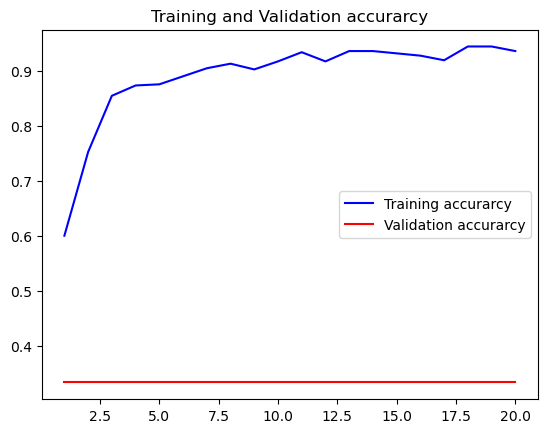

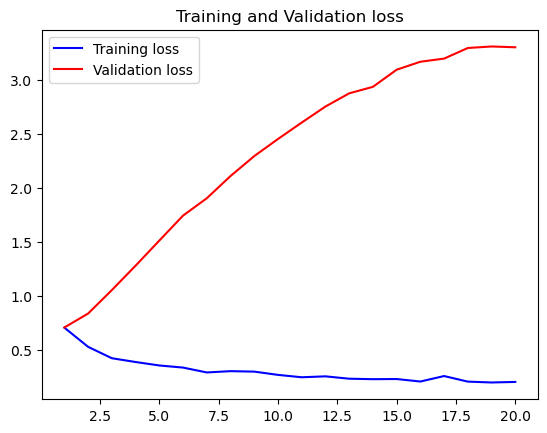

[INFO] Calculating model accuracy
4/4 [==============================] - 1s 301ms/step - loss: 3.3012 - accuracy: 0.3333
Test Accuracy: 33.33333432674408


In [27]:
"""# Оценка модели
Сравнение точности и потерь путем построения графика для обучения и проверки.
"""

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Точность обучения и проверки
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Обучение и потеря проверки
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

"""Оценка точности модели с использованием метода «оценить»"""

print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

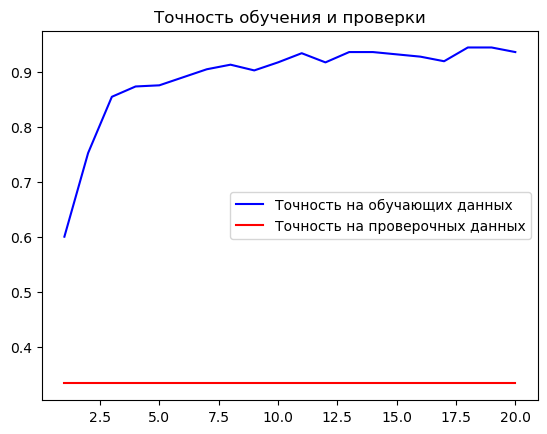

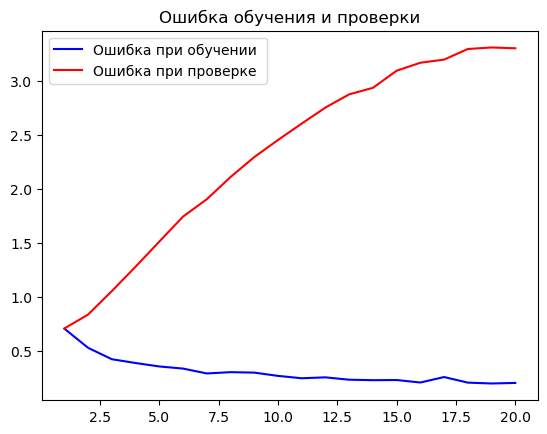

[INFO] Calculating model accuracy
4/4 [==============================] - 1s 305ms/step - loss: 3.3012 - accuracy: 0.3333
Test Accuracy: 33.33333432674408


In [28]:
"""# Оценка модели
Сравнение точности и потерь путем построения графика для обучения и проверки.
"""

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Точность обучения и проверки
plt.plot(epochs, acc, 'b', label='Точность на обучающих данных')
plt.plot(epochs, val_acc, 'r', label='Точность на проверочных данных')
plt.title('Точность обучения и проверки')
plt.legend()

plt.figure()

# Обучение и потеря проверки
plt.plot(epochs, loss, 'b', label='Ошибка при обучении')
plt.plot(epochs, val_loss, 'r', label='Ошибка при проверке ')
plt.title('Ошибка обучения и проверки')
plt.legend()
plt.show()

"""Оценка точности модели с использованием метода «оценить»"""

print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

In [28]:
#Сохранение модели

# model.save('PDD_completemodel')
# model.save('PDD_completemodel.h5')
#intermediate_layer_model.save('PDD_IntermediateModel')
#intermediate_layer_model.save('PDD_IntermediateModel.h5')

In [29]:
x_train_predict = intermediate_layer_model.predict(x_train)
# print(x_train_predict.shape)

x_test_predict = intermediate_layer_model.predict(x_test)
print(x_test_predict.shape)

4/4 [==============================] - 1s 309ms/step
(120, 1024)


## Машина опорных векторов
Интеграция CNN с машиной опорных векторов.

In [30]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')

svm.fit(x_train_predict,np.argmax(y_train,axis=1))

print('SVM Fit Complete')

SVM Fit Complete


In [31]:
svm.score(x_train_predict,np.argmax(y_train,axis=1))

0.99375

In [32]:
svm.score(x_test_predict,np.argmax(y_test,axis=1))

#Save the SVM model in pickle file
# pickle.dump(svm,open('svms.pkl', 'wb'))

0.975

In [33]:
Pred_labels = svm.predict(x_test_predict)
Pred_labels = pd.DataFrame(Pred_labels,index =None)
Pred_labels.head()

,0
0,1
1,1
2,2
3,0
4,1


# Интеграция XGBoost

Интеграция модели CNN с алгоритмом Extreme Gradient Boost.

In [34]:
import xgboost as xgb

xb = xgb.XGBClassifier(use_label_encoder=False)

xb.fit(x_train_predict,np.argmax(y_train,axis=1))

print('XGBoost Fit Complete')

#Save XGBoost Model
# pickle.dump(xb,open('xgb_model.pkl','wb'))

XGBoost Fit Complete


In [35]:
xb.score(x_train_predict,np.argmax(y_train,axis=1))

1.0

In [36]:
xb.score(x_test_predict,np.argmax(y_test,axis=1))

0.9833333333333333

In [13]:
# from tensorflow.keras.models import load_model

# ai = load_model('D:\PDD_Models\HDF5\PDD_Intermediatemodel.h5')
# xgb_model = xgb.XGBClassifier()
# xgb_model.load_model(r'D:\PDD_Models\xgb_model.json')

# x2 = ai.predict(x_test)
# xgb_model.score(x_test_predict,np.argmax(y_test,axis=1))

# Дальнейшие улучшения

- Методы обработки изображений могут быть реализованы до подхода к входному слою CNN.
- Разработка системы PDD [обнаружения болезней растений] в реальном времени с использованием Opencv
- Улучшение потерь при проверке
- Более широкий спектр дополнений и манипуляций с данными для повышения производительности.
- Интеграция CNN с другими архитектурами
- Настройка гиперпараметров
- Дополнительные наборы данных
- Front End разработка [Django, Flask, HTML+CSS+JS, Kotlin, Java, Swift, Flutter]
- Разработка кроссплатформенных приложений
- Развертывание модели ИИ на компьютерах-компаньонах для приложений в реальном времени.